# Upload dataset from Kaggle


Use Kaggle API


In [ ]:
from google.colab import files
# Upload kaggle.json
files.upload()

In [ ]:
!pip install kaggle

# create a directory for the Kaggle configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# use the Kaggle API to download the dataset
!kaggle datasets download -d marquis03/high-resolution-viton-zalando-dataset

# Unzip the downloaded dataset
!unzip high-resolution-viton-zalando-dataset.zip -d viton_dataset

# Data Preprocessing


In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

dataset_path = '/content/viton_dataset/train/cloth/'

# function to preprocess an image
def load_and_preprocess_image(image_path):
    # resize to VGG16 input size
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# preprocess all images in the dataset
def load_dataset(dataset_path):
    images = []
    for filename in os.listdir(dataset_path):
        image_path = os.path.join(dataset_path, filename)
        image = load_and_preprocess_image(image_path)
        images.append(image)
    return np.vstack(images)

images = load_dataset(dataset_path)


# Building CNN Model


## VGG16


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D

def load_model():
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    # freezing the layers
    vgg16.trainable = False

    vgg16_model = Sequential([
        vgg16,
        GlobalMaxPooling2D()
    ])

    return vgg16_model


# Feature Extraction


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Load the VGG-16 model - (currently using ResNet50)
vgg16 = load_model()

# Load the ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()


In [ ]:
import os
import pandas as pd

dataset_path = '/content/viton_dataset/train/cloth/'
feature_list = []
metadata = []

# list files and process them
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(dataset_path, filename)
        features = extract_features(img_path)
        feature_list.append(features)

        # use the filename as the ID
        id = filename
        print(id)
        print(len(feature_list))
        
        # Prepare metadata
        file_path = os.path.join(dataset_path, filename)
        metadata.append({'id': id, 'filename': filename, 'path': file_path})


In [ ]:
len(feature_list)

11647

In [ ]:
feature_list[:5]

[array([0.28651187, 5.076293  , 0.23147933, ..., 0.01470183, 0.07612606,
        0.94015086], dtype=float32),
 array([0.12197728, 3.2597377 , 0.47953898, ..., 0.5882222 , 0.24142784,
        0.15784536], dtype=float32),
 array([ 0.        , 10.147991  ,  0.6926977 , ...,  0.01903645,
         0.39749247,  1.6924801 ], dtype=float32),
 array([0.        , 7.658969  , 0.12465989, ..., 0.3130816 , 0.        ,
        0.26663032], dtype=float32),
 array([0.        , 5.1262255 , 0.36477405, ..., 0.01306739, 0.        ,
        1.1932268 ], dtype=float32)]

In [ ]:
len(feature_list[0])

2048

In [ ]:
# Check the shape of the output vector
output_shape = model.output_shape
print("Model output shape:", output_shape)

Model output shape: (None, 2048)


We observe that the dataset contains 11,647 data points. After applying feature extraction, each clothing item is represented as a vector with 2,048 dimensions with each dimension corresponding to a different feature.


# Vector Embedding


In [ ]:
def embed_dataset(image_paths):
    embeddings = []
    for img_path in image_paths:
        features = extract_features(img_path)
        embeddings.append(features)

    # convert embeddings to a DataFrame
    df_embeddings = pd.DataFrame(embeddings)
    return df_embeddings


In [ ]:
def get_image_paths(directory_path):
    image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    return image_paths

# get all image paths from the dataset directory
dataset_path = '/content/viton_dataset/train/cloth/'
image_paths = get_image_paths(dataset_path)

In [ ]:
# get the embeddings DataFrame
df_embeddings = embed_dataset(image_paths)

In [ ]:
print(df_embeddings.head())

       0          1         2         3         4         5         6     \
0  0.286512   5.076293  0.231479  0.000000  0.118222  0.000000  0.024046   
1  0.121977   3.259738  0.479539  0.110349  0.161641  0.064817  0.000000   
2  0.000000  10.147991  0.692698  0.000000  0.000000  0.164780  0.594099   
3  0.000000   7.658969  0.124660  0.000000  0.196029  0.137789  0.183361   
4  0.000000   5.126225  0.364774  0.000000  0.792882  0.000000  0.215830   

       7         8        9     ...      2038      2039      2040      2041  \
0  0.171124  0.059431  0.01826  ...  0.000000  0.134886  0.003136  0.421646   
1  0.048861  0.006844  0.00000  ...  0.347186  0.568658  0.014264  0.618718   
2  0.377142  0.000000  0.00000  ...  0.104397  0.869890  0.000000  0.348840   
3  0.340893  0.000561  0.00000  ...  0.078792  0.396925  0.095898  0.076403   
4  0.000000  0.033852  0.00000  ...  0.000000  0.106210  0.047729  0.207587   

       2042      2043      2044      2045      2046      2047  
0  0

We cab observe that we have successfully embedded each image into the vector.


# Query Similar Images


In [ ]:
# user upload
user_image_path = '/content/cloth3.jpg'  # Replace with the actual path to user image
user_image_features = extract_features(user_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
user_image_features

array([[0.        , 0.16595477, 0.        , ..., 0.00259242, 0.18028228,
        0.        ]], dtype=float32)

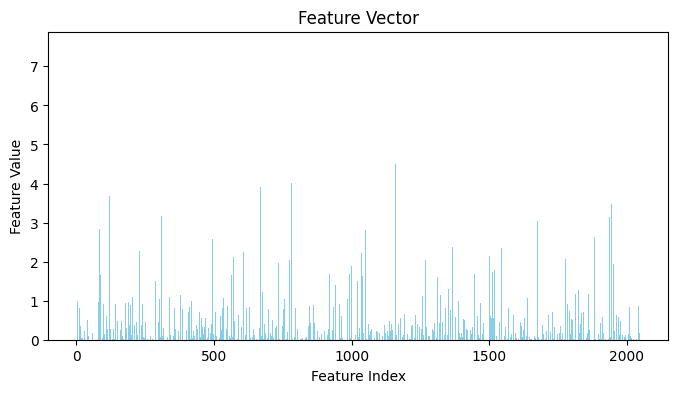

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_vector(features):
    # flatten the feature vector if it is 2D
    if features.ndim > 1:
        features = features.flatten()

    # ensure features is a 1D array
    features = np.array(features)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(features)), features, color='skyblue')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('Feature Vector')
    plt.show()

# vector feature demonstration
plot_feature_vector(user_image_features)


Feature vector of the uploaded image.


In [ ]:
# Reshape to (1, 2048)
user_image_features = np.array(extract_features(user_image_path)).reshape(1, -1)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
print("Shape of dataset_embeddings:", df_embeddings.shape)
print("Shape of user_image_features:", user_image_features.shape)

Shape of dataset_embeddings: (11647, 2048)
Shape of user_image_features: (1, 2048)


We have now ensured that the user uploaded image and the embeddings are both two dimensional arrays.


Now we will observe varying methods of similarity functions to determine similar clothing.


## Cosine Similarity


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_images_cosine(user_image_features, dataset_embeddings):
    # compute cosine similarity
    similarities = cosine_similarity(user_image_features, dataset_embeddings)

    # get indices of the most similar images
    similar_indices = np.argsort(similarities[0])[::-1]  # Sort in descending order
    return similar_indices, similarities

# example usage
indices, sim = find_similar_images_cosine(user_image_features, df_embeddings)

# display results
print("Indices of similar images:", indices)
print("Cosine similarities:", sim)


Indices of similar images: [ 9482  4609  2112 ...  2306  5906 10933]
Cosine similarities: [[0.50216675 0.3325839  0.5034878  ... 0.47262847 0.6142889  0.37694708]]


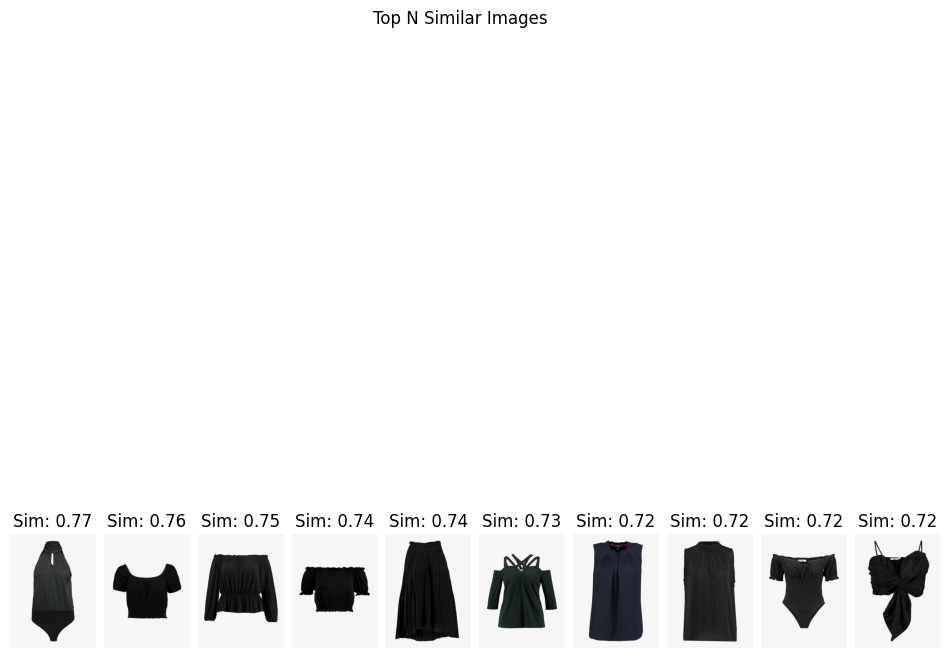

In [71]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#function to list all image files in a directory
def get_image_paths(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}  # Add more extensions if needed
    image_paths = [os.path.join(directory, f) for f in os.listdir(directory)
                   if os.path.splitext(f)[1].lower() in image_extensions]
    return image_paths

def visualize_cosine_similarity_images(user_image_features, dataset_embeddings, image_paths, top_n=10):
    indices, similarities = find_similar_images_cosine(user_image_features, dataset_embeddings)

    # top N similar images
    top_indices = indices[:top_n]
    top_similarities = similarities[0][top_indices]

    #  length of image_paths and top_indices
    if len(image_paths) < len(top_indices):
        raise ValueError("Length of image_paths is less than the number of top_indices.")

    fig, axes = plt.subplots(1, top_n, figsize=(12, 12), squeeze=False)
    # adjust spacing between subplots
    fig.subplots_adjust(wspace=0.1, hspace=0)  

    for i, idx in enumerate(top_indices):
        if idx >= len(image_paths):
            print(f"Index {idx} is out of range for image_paths.")
            continue
        ax = axes[0, i]
        img = mpimg.imread(image_paths[idx])
        ax.imshow(img)
        ax.set_title(f"Sim: {top_similarities[i]:.2f}")
        ax.axis('off')

    plt.suptitle('Top N Similar Images')
    plt.show()

# get the list of image paths from the directory
dataset_image_paths = get_image_paths(dataset_path)

visualize_cosine_similarity_images(user_image_features, df_embeddings, dataset_image_paths)
